In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import scipy
import matplotlib.dates as mdates
from datetime import datetime
from iminuit import Minuit
from scipy import stats
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import chi2
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SMPS = read_SMPS(path, parent_path, [0, 0])
OPS_APS = read_OPS(path, parent_path)

NS_dict_keys = ['2024-10-15_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan']
NS_bins = SMPS['2024-10-21_NanoScan'].keys()[3:16].to_list()

NS_bg_mean, NS_bg_std, NS_bg_error = bin_mean(['2024/10/21 11:45:00', '2024/10/21 14:10:00'], 
                                              SMPS['2024-10-21_NanoScan'], NS_bins, 'Time', 0.1)

for key in NS_dict_keys:
    df = SMPS[key]
    for i, bin in enumerate(NS_bins):
        df[bin] = df[bin] - NS_bg_mean[i]

    SMPS[key] = df

Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,
Failed to read file with separation: 	
Failed to read file with separation: ,
Failed to read file with separation: ,


In [3]:
APS_dict_keys = ['20241016_APS', '20241016_APS_2_exp', '20241017_APS', '20241017_APS']
APS_bins = OPS_APS['20241016_APS'].keys()[1:53].to_list()
APS_bin_mean = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean.append(float(key))
    OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce') * 7.86
APS_cut_point = np.concatenate(([0.486968], (np.array(APS_bin_mean)[1:]+np.array(APS_bin_mean)[:-1])/2, [20.53]))

APS_mass_conc = {}
APS_mass_conc['20241016_APS'] = OPS_APS['20241016_APS']
for key in APS_dict_keys[1:3]:
    for i, bin in enumerate(APS_bins):
        bin_width = np.log10(APS_cut_point[i+1]) - np.log10(APS_cut_point[i])
        OPS_APS[key][bin] = pd.to_numeric(OPS_APS[key][bin]) * bin_width
    mass_conc = calc_mass_conc(OPS_APS[key], APS_bins, APS_bin_mean, 7.86)
    APS_mass_conc[key] = mass_conc

APS_number = pd.DataFrame({'Time': OPS_APS['20241016_APS']['Time']})
for i, key in enumerate(APS_bins):
        # Ensure df[key] is numeric
        OPS_APS['20241016_APS'][key] = pd.to_numeric(OPS_APS['20241016_APS'][key], errors='coerce')
        
        APS_number[key] = OPS_APS['20241016_APS'][key] / ((7.86 / 10**6) * (np.pi / 6) * APS_bin_mean[i]**3 * 10**6) # in #/cm**3
OPS_APS['20241016_APS'] = APS_number

SMPS_dict_keys = ['20241016_SMPS', '20241016_SMPS_2_exp', '20241017_SMPS', '20241017_SMPS']
SMPS_bins = SMPS['20241016_SMPS'].keys()[4:117].to_list()
SMPS_bin_mean = []
for key in SMPS['20241016_SMPS'].keys()[4:117]:
    SMPS_bin_mean.append(float(key) / 1000)
SMPS_cut_point = np.concatenate(([0.017], (np.array(SMPS_bin_mean)[1:]+np.array(SMPS_bin_mean)[:-1])/2, [1.0]))

for key in SMPS_dict_keys[:3]:
    for i, bin in enumerate(SMPS_bins):
        bin_width = np.log10(SMPS_cut_point[i+1]) - np.log10(SMPS_cut_point[i])
        SMPS[key][bin] = pd.to_numeric(SMPS[key][bin]) * bin_width

[ 0.486968  0.523492  0.5625    0.6045    0.6495    0.698     0.75
  0.806     0.8665    0.9315    1.001     1.0755    1.1555    1.2415
  1.334     1.434     1.541     1.6555    1.779     1.912     2.055
  2.2085    2.373     2.55      2.7405    2.945     3.1645    3.4005
  3.6545    3.927     4.2195    4.5345    4.873     5.2365    5.627
  6.0465    6.498     6.983     7.504     8.064     8.6655    9.312
 10.0085   10.755    11.555    12.415    13.34     14.34     15.41
 16.555    17.79     19.12     20.53    ]


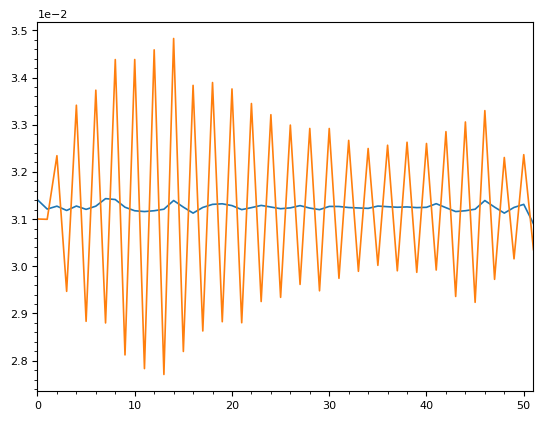

In [4]:
APS_bin_mean1 = [np.sqrt(0.486968 * 0.523)]
APS_bin_mean2 = [(0.486968 + 0.523)/2]
for key in OPS_APS['20241016_APS'].keys()[2:53]:
    APS_bin_mean1.append(float(key))
    APS_bin_mean2.append(float(key))
APS_cut_point1 = bin_edges(0.486968, APS_bin_mean1)
APS_cut_point2 = np.concatenate(([0.486968], (np.array(APS_bin_mean2)[1:]+np.array(APS_bin_mean2)[:-1])/2, [20.53]))
print(APS_cut_point)
# plt.plot()
# plt.plot(APS_cut_point1- APS_cut_point2)
plt.plot(np.log10(APS_cut_point2[1:])- np.log10(APS_cut_point2[:-1]))
plt.plot(np.log10(np.array(APS_cut_point1)[1:])-np.log10(np.array(APS_cut_point1)[:-1]))

In [4]:
timestamps_exp = [['2024-10-16 10:45:00', '2024-10-16 12:26:00'],
                  ['2024-10-16 15:00:00', '2024-10-16 15:34:00'],
                  ['2024-10-17 10:20:00', '2024-10-17 12:00:00'],
                  ['2024-10-17 14:30:00', '2024-10-17 15:00:00']]

ax_labels = ['Particle diameter / $\mu$m', 'dN / #/cm$^{3}$', 'dM / $\mu$g/m$^{3}$']

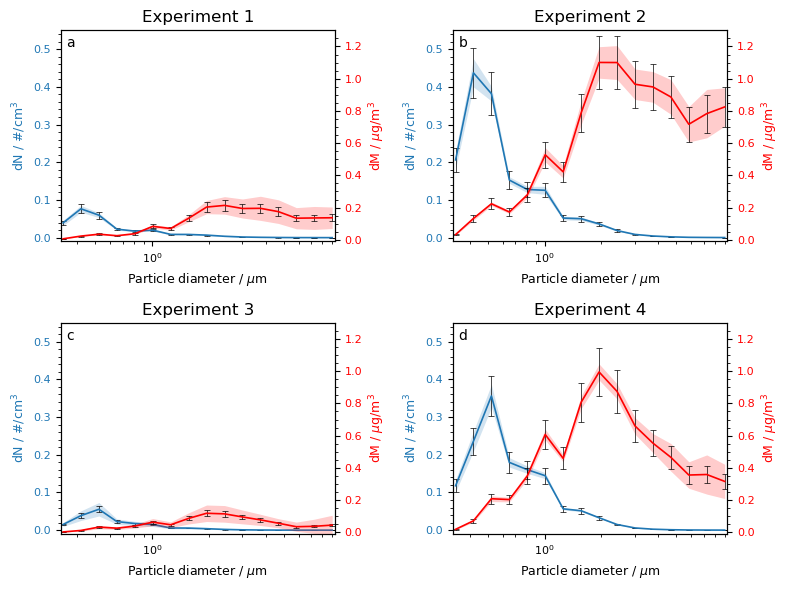

In [5]:
OPS_dict_keys = ['Exp1', 'Exp2', 'Exp3', 'Exp4']
OPS_mid_point = [0.337, 0.419, 0.522, 0.650, 0.809, 1.007, 1.254, 1.562, 1.944, 2.421, 3.014, 3.752, 4.672, 5.816, 7.241, 9.015]
OPS_cut_point = [0.300, 0.374, 0.465, 0.579, 0.721, 0.897, 1.117, 1.391, 1.732, 2.156, 2.685, 3.343, 4.162, 5.182, 6.451, 8.031, 10.000]
OPS_bins = OPS_APS['Exp1'].keys()[1:17].to_list()

OPS_mass_conc = {}
for key in OPS_dict_keys:
    mass_conc = calc_mass_conc(OPS_APS[key], OPS_bins, OPS_mid_point, 7.86)
    OPS_mass_conc[key] = mass_conc

OPS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], OPS_APS[key], OPS_mass_conc[key], OPS_bins, 'Time', OPS_mid_point, ['tab:blue', 'red'], 0.15, ax_labels, True, None)
    OPS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': np.array(OPS_mid_point), 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_xlim(min(OPS_mid_point) - 0.01, max(OPS_mid_point) + 0.3)
    ax.set_ylim(-0.01, 0.55)
    ax2.set_ylim(-0.01, 1.3)
    
    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/OPS_mean.png', dpi = 600)

In [ ]:
# Gaussian function definition
def single_gaussian(x, sigma, mu, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)

# Function to detect shoulders
def detect_shoulders(x, y, threshold=0.1):
    """Detect shoulders based on second derivative (curvature) and slope changes."""
    dy = np.diff(y)  # First derivative
    d2y = np.diff(dy)  # Second derivative
    
    shoulders = []
    for i in range(2, len(d2y) - 2):  # Avoid edges
        if d2y[i - 1] > 0 and d2y[i + 1] < 0:  # Curvature peak (up to down)
            if abs(dy[i]) < threshold:  # Low slope region
                shoulder_start = x[i - 1]
                shoulder_end = x[i + 1]
                shoulders.append((shoulder_start, shoulder_end))
    
    return shoulders

# Function to fit a single Gaussian using Minuit
def fit_single_peak(x, y, sy, initial_guess):
    def chi2_single(sigma, mu, A):
        y_fit = single_gaussian(x, sigma, mu, A)
        chi2 = np.sum(((y - y_fit) / sy) ** 2)
        return chi2

    try:
        minuit = Minuit(chi2_single, *initial_guess)
        minuit.limits = [(1e-3, None), (None, None), (0, np.max(y))]  # Constrain A to be non-negative
        minuit.migrad()  # Perform minimization
        return minuit.values, minuit.errors
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, None

# Main function to find and fit peaks and shoulders
def find_gauss_peaks(x, y, sy, threshold=0.1):
    x, y, sy = np.array(x), np.array(y), np.array(sy)

    # Step 1: Detect peaks
    peaks, _ = find_peaks(y, prominence=1e-2, height=1e-3)
    if len(peaks) == 0:
        print("No peaks detected. Adjust parameters.")
        return np.zeros_like(x), [], [], [], []  # Return empty results if no peaks

    mu_guess_peaks = x[peaks]
    A_guess_peaks = y[peaks]
    sigma_guess_peaks = [0.1] * len(peaks)  # Uniform initial guess for width

    # Step 2: Detect shoulders using second derivative
    shoulders = detect_shoulders(x, y, threshold)

    # Step 3: Initialize results
    peak_results = []
    shoulder_results = []
    df = pd.DataFrame({'x fit': np.linspace(min(x), max(x), 1000)})

    # Step 4: Fit peaks
    for i, peak_idx in enumerate(peaks):
        peak_initial_guess = [sigma_guess_peaks[i], mu_guess_peaks[i], A_guess_peaks[i]]
        print(f"Peak initial guess: {peak_initial_guess}")
        fit_x = x[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        fit_y = y[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        fit_sy = sy[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]

        peak_params, peak_errors = fit_single_peak(fit_x, fit_y, fit_sy, peak_initial_guess)
        if peak_params is not None:
            df[f'Peak {i + 1}'] = single_gaussian(df['x fit'], *peak_params)
            peak_results.append((peak_params, peak_errors))

    # Step 5: Fit shoulders
    for i, shoulder in enumerate(shoulders):
        shoulder_mu = np.mean(shoulder)
        shoulder_center_idx = np.argmin(np.abs(x - shoulder_mu))
        shoulder_sigma = (shoulder[1] - shoulder[0]) / (2 * np.sqrt(2 * np.log(2)))  # Approx FWHM -> sigma
        shoulder_A = y[shoulder_center_idx]

        start_idx = max(0, int(np.searchsorted(x, shoulder[0])))
        end_idx = min(len(x) - 1, int(np.searchsorted(x, shoulder[1])))
        fit_x = x[start_idx:end_idx]
        fit_y = y[start_idx:end_idx]
        fit_sy = sy[start_idx:end_idx]

        shoulder_initial_guess = [shoulder_sigma, shoulder_mu, shoulder_A]
        print(f"Shoulder initial guess: {shoulder_initial_guess}")
        shoulder_params, shoulder_errors = fit_single_peak(fit_x, fit_y, fit_sy, shoulder_initial_guess)
        if shoulder_params is not None:
            df[f'Shoulder {i + 1}'] = single_gaussian(df['x fit'], *shoulder_params)
            shoulder_results.append((shoulder_params, shoulder_errors))

    # Combine peak and shoulder parameters
    fitted_params_all = []
    errors_all = []
    for result in peak_results + shoulder_results:
        if result[0] is not None:
            fitted_params_all.append(result[0])
            errors_all.append(result[1])

    # Calculate chi-squared and probability
    y_fit_combined = np.sum([single_gaussian(x, *params[0]) for params in peak_results + shoulder_results], axis=0)
    chi2_value = np.sum(((y - y_fit_combined) / sy) ** 2)
    Ndof_fit = len(y) - len(fitted_params_all) * 3  # 3 params per Gaussian
    Prob_value = chi2.sf(chi2_value, Ndof_fit)

    print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_fit:.0f}    Prob(Chi2,Ndof) = {Prob_value:.3f}")

    return df, mu_guess_peaks, A_guess_peaks, fitted_params_all, errors_all


In [27]:

# Gaussian function definition
def single_gaussian(x, sigma, mu, A):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (np.sqrt(2 * np.pi) * sigma)

# Multi-Gaussian model for combined fitting
def multi_gaussian(x, *params):
    gaussians = [
        single_gaussian(x, params[i], params[i + 1], params[i + 2])
        for i in range(0, len(params), 3)
    ]
    return np.sum(gaussians, axis=0)

# Detect shoulders
def detect_shoulders(x, y, threshold=0.1):
    dy = np.diff(y)
    d2y = np.diff(dy)
    shoulders = []
    for i in range(2, len(d2y) - 2):
        if d2y[i - 1] > 0 and d2y[i + 1] < 0 and abs(dy[i]) < threshold:
            shoulders.append((x[i - 1], x[i + 1]))
    return shoulders

# Fit function for a single Gaussian
def fit_single_peak(x, y, sy, initial_guess):
    def chi2_single(sigma, mu, A):
        y_fit = single_gaussian(x, sigma, mu, A)
        chi2 = np.sum(((y - y_fit) / sy) ** 2)
        return chi2

    minuit = Minuit(chi2_single, *initial_guess)
    minuit.limits = [(1e-3, None), (None, None), (0, np.max(y))]
    minuit.migrad()
    return minuit.values, minuit.errors

# Main function for fitting
def find_gauss_peaks(x, y, sy, threshold=0.1):
    x, y, sy = np.array(x), np.array(y), np.array(sy)
    df = pd.DataFrame({'x fit': np.linspace(min(x), max(x), 1000)})

    # Step 1: Detect peaks
    peaks, _ = find_peaks(y)
    mu_guess_peaks = x[peaks]
    A_guess_peaks = y[peaks]
    sigma_guess_peaks = [np.ptp(x) / (2 * len(peaks))] * len(peaks)

    # Step 2: Detect shoulders
    shoulders = detect_shoulders(x, y, threshold)

    # Step 3: Fit peaks
    peak_results = []
    for i, peak_idx in enumerate(peaks):
        peak_initial_guess = [sigma_guess_peaks[i], mu_guess_peaks[i], A_guess_peaks[i]]
        fit_x = x[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        fit_y = y[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        fit_sy = sy[max(peak_idx - 10, 0): min(peak_idx + 10, len(x))]
        peak_params, peak_errors = fit_single_peak(fit_x, fit_y, fit_sy, peak_initial_guess)
        df[f'Peak {i + 1}'] = single_gaussian(df['x fit'], *peak_params)
        peak_results.append(peak_params)

    # Step 4: Fit shoulders
    shoulder_results = []
    for i, shoulder in enumerate(shoulders):
        shoulder_mu = np.mean(shoulder)
        shoulder_sigma = (shoulder[1] - shoulder[0]) / 3
        shoulder_center_idx = np.argmin(np.abs(x - shoulder_mu))
        shoulder_A = y[shoulder_center_idx]
        start_idx = max(0, np.searchsorted(x, shoulder[0]))
        end_idx = min(len(x) - 1, np.searchsorted(x, shoulder[1]))
        fit_x = x[start_idx:end_idx]
        fit_y = y[start_idx:end_idx]
        fit_sy = sy[start_idx:end_idx]
        shoulder_initial_guess = [shoulder_sigma, shoulder_mu, shoulder_A]
        shoulder_params, shoulder_errors = fit_single_peak(fit_x, fit_y, fit_sy, shoulder_initial_guess)
        df[f'Shoulder {i + 1}'] = single_gaussian(df['x fit'], *shoulder_params)
        shoulder_results.append(shoulder_params)

    return df

def plot_gauss_fit(ax, x, y, sy, datatype):

    df = find_gauss_peaks(x, y, sy)
    
    n_lines = len(df.keys()) - 1
    cmap = mpl.colormaps['brg']
    colors = cmap(np.linspace(0, 1, n_lines))

    # Plot data and fit
    # ax.plot(x, y, label="Data")
    ax.errorbar(x, y, sy, ecolor='k', elinewidth=0.5, capsize=2, capthick=0.5, label = 'Data', color = 'k')
    
    for key, clr in zip(df.keys()[1:], colors):
        ax.plot(df['x fit'],  df[key], label=key + " fit", linestyle="--", color = clr, zorder = 5)
    ax.legend(fontsize = 8)
    ax.set(xscale='log', xlabel='Particle diameter / $\mu$m')
    if datatype == 'number':
        ax.set_ylabel('dN / #/cm$^{3}$')
    if datatype == 'mass':
        ax.set_ylabel('dM / $\mu$/m$^{3}$')

    return ax, df

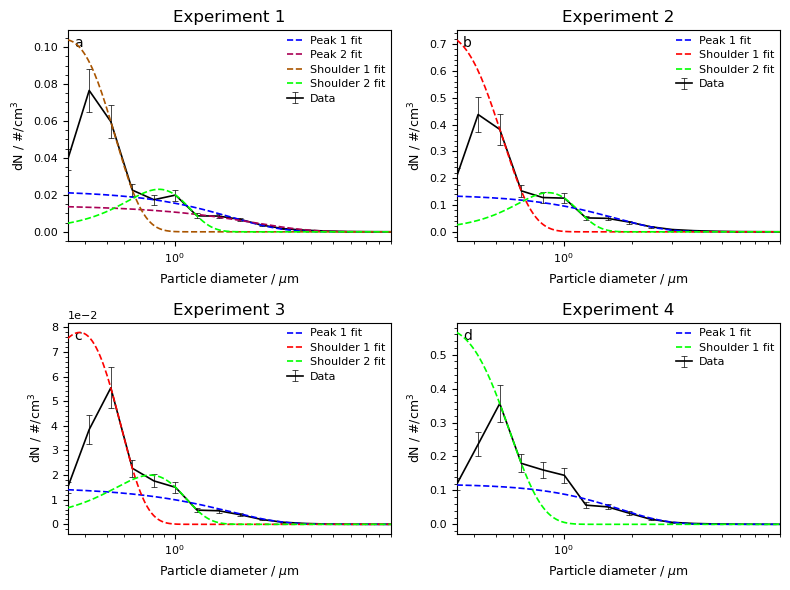

In [29]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]
    
    df = OPS_mean_conc[key]
    ax, y_fit = plot_gauss_fit(ax, df['Diameter'], df['number'], df['error number'], 'number')

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Gaussian_fits/OPS_fitted_number.png', dpi = 600)

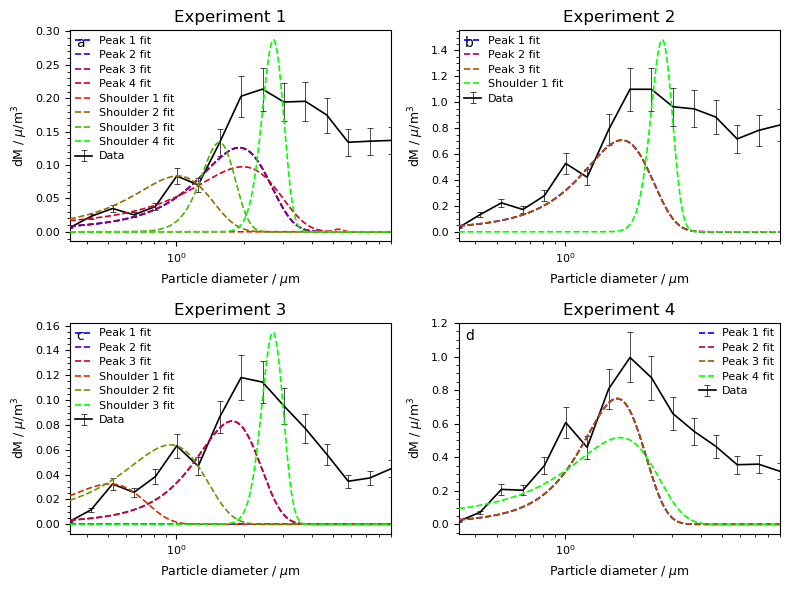

In [28]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(OPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]
    
    df = OPS_mean_conc[key]
    ax, y_fit = plot_gauss_fit(ax, df['Diameter'], df['mass'], df['error mass'], 'mass')

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Gaussian_fits/OPS_fitted_mass.png', dpi = 600)

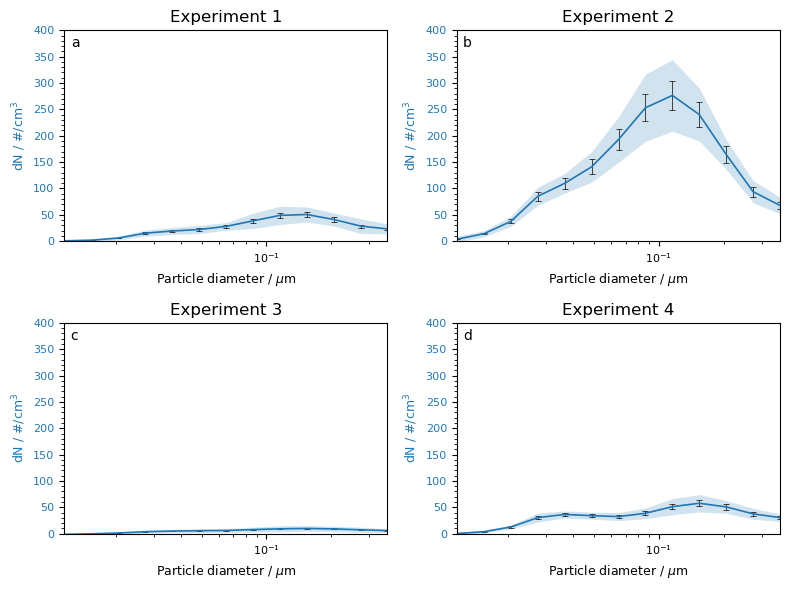

In [ ]:
NanoScan_dict_keys = ['2024-10-16_NanoScan', '2024-10-16_NanoScan', '2024-10-17_NanoScan', '2024-10-17_NanoScan']
NanoScan_bin_mean = []
for key in SMPS['2024-10-16_NanoScan'].keys()[3:16]:
    NanoScan_bin_mean.append(float(key) / 1000)
NanoScan_Bins = SMPS['2024-10-16_NanoScan'].keys()[3:16].to_list()

NS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(NanoScan_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS[key], None, NanoScan_Bins, 'Time', NanoScan_bin_mean, ['tab:blue'], 0.10, ax_labels, False, None)
    NS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': NanoScan_bin_mean, 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_ylim(-0.5, 400)

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/NanoScan_mean.png', dpi = 600)

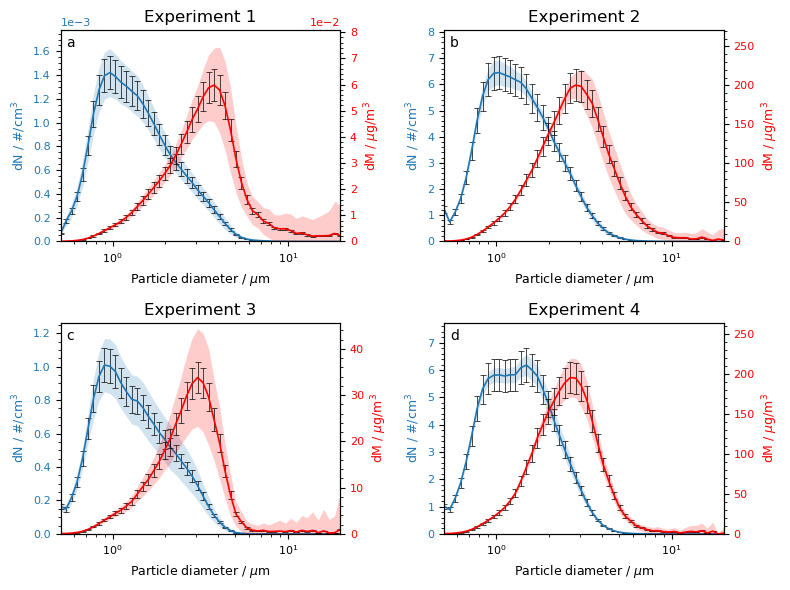

In [ ]:
APS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(APS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], OPS_APS[key], APS_mass_conc[key], APS_bins, 'Time', APS_bin_mean, ['tab:blue', 'red'], 0.10, ax_labels, True, None)
    APS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': APS_bin_mean, 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_ylim(0, max(number) + 0.25 * max(number))
    ax2.set_ylim(0, max(mass) + 0.35 * max(mass))

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)

sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/APS_mean.png', dpi = 600)

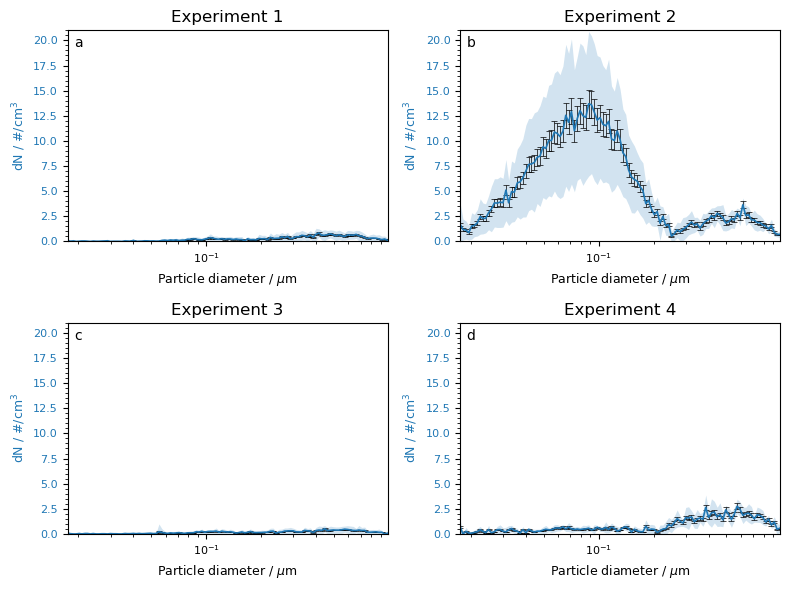

In [ ]:
SMPS_mean_conc = {}

fig, axes = plt.subplots(2, 2, figsize = (8, 6))

for i, key in enumerate(SMPS_dict_keys):
    if i == 0:
        ax = axes[0][0]
    if i == 1:
        ax = axes[0][1]
    if i == 2:
        ax = axes[1][0]
    if i == 3:
        ax = axes[1][1]

    number, error_number, mass, error_mass, ax, ax2 = plot_bin_mean(ax, timestamps_exp[i], SMPS[key], None, SMPS_bins, 'Time', SMPS_bin_mean, ['tab:blue'], 0.10, ax_labels, False, None)
    SMPS_mean_conc['Exp'+str(i+1)] = pd.DataFrame({'Diameter': SMPS_bin_mean, 'number': number, 'error number': error_number, 'mass': mass, 'error mass': error_mass})

    ax.set_ylim(0, 21)

    title = 'Experiment ' + str(i + 1)
    ax.set_title(title)
    
sublabels = ['a', 'b', 'c', 'd']
for ax, l in zip(axes.flatten(), sublabels):
    ax.text(0.02, 0.92, l, transform = ax.transAxes, fontsize = 10)

fig.tight_layout()
fig.savefig('Mean_concentrations/SMPS_mean.png', dpi = 600)